In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
#LOADING IMAGES FROM FOLDER
#BLACK AND WHITE SCALE IS APPLIED
#IMG SIZE IS 128X128 PIXEL FOR DEFAULT
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    labels = []

    for label_folder in os.listdir(folder):
        if label_folder.startswith('.'):
            continue
        label_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    if label_folder == 'NORMAL':
                        labels.append(0)
                    else:
                        labels.append(1)

    return np.array(images), np.array(labels)

In [ ]:
#FLATTENING IS ESSENTIAL FOR PIXEL VALUES
def flatten_images(images):
    n_samples = images.shape[0]
    return images.reshape((n_samples, -1))  # Flatten each image

In [ ]:
#UPLOADING DATASET

train = '/content/drive/MyDrive/CS464 project/chest_xray/train'
val =  '/content/drive/MyDrive/CS464 project/chest_xray/val'
test = '/content/drive/MyDrive/CS464 project/chest_xray/test'

train_X, train_Y =load_images_from_folder(train, img_size=(128, 128))
val_X, val_Y =load_images_from_folder(val, img_size=(128, 128))
test_X, test_Y =load_images_from_folder(test, img_size=(128, 128))

train_X = flatten_images(train_X)
val_X = flatten_images(val_X)
test_X = flatten_images(test_X)

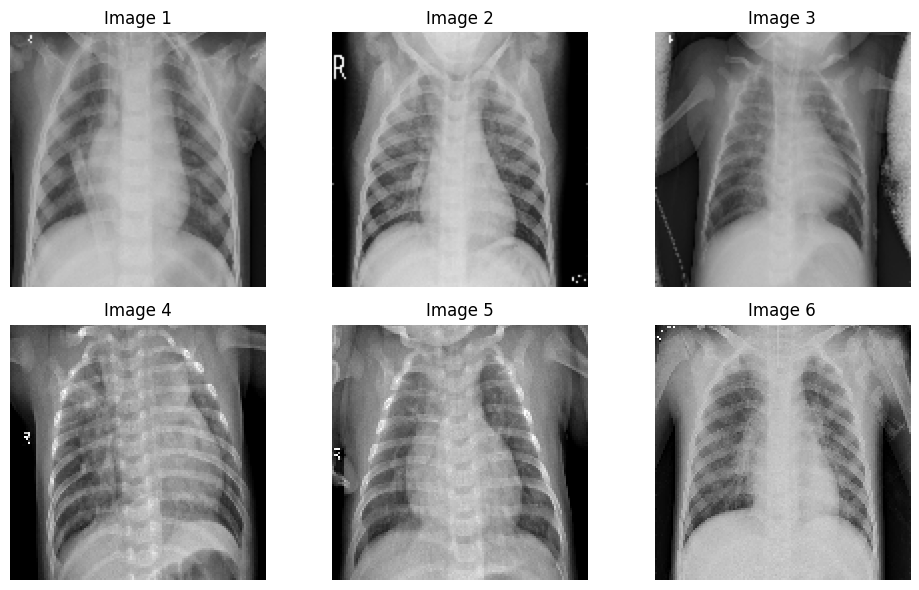

In [ ]:
# Assuming train_X contains the flattened images
# Reshape the images back to their original dimensions for display
train_X_reshaped = train_X.reshape(-1, 128, 128)

# Display the first 6 images
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(6):
    ax = axes[i // 3, i % 3]
    ax.imshow(train_X_reshaped[i], cmap='gray')  # Use cmap='gray' for grayscale images
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#PARAMETER TUNING WITH VALIDATION /SINCE OUR CLASSES DO NOT HAVE SAME NUMBER OF IMAGES, WE CALCUALTED F-STATISTIC INSTEAD OF ACCURACY FOR TUNING

n_estimators = [100, 200, 300]
max_depth = [10, 20, 30]
min_samples_split = [2, 10]
min_samples_leaf = [1,  4]
max_features = ['sqrt', 'log2']
f1_results = []

for n in n_estimators:
  for d in max_depth:
    for s in min_samples_split:
      for l in min_samples_leaf:
        for f in max_features:
            rf_model = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42, min_samples_leaf=l, min_samples_split = s, max_features = f)
            rf_model.fit(train_X, train_Y)
            val_predictions = rf_model.predict(val_X)
            f1 = f1_score(val_Y, val_predictions)
            f1_results.append(f1)
            print(f"n_estimators={n}, max_depth={d}, min_samples_split={s}, min_samples_leaf={l}, max_features={f} F1 Score: {f1}")


n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt F1 Score: 0.7448275862068966
n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=log2 F1 Score: 0.7632508833922261
n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=sqrt F1 Score: 0.7448275862068966
n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=4, max_features=log2 F1 Score: 0.7578947368421053
n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt F1 Score: 0.7474048442906575
n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features=log2 F1 Score: 0.7632508833922261
n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features=sqrt F1 Score: 0.7422680412371134
n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features=log2 F1 Score: 0.7561837455830389
n_estimators=100, max_depth=20, min_

In [ ]:
#TEST ACCURACY WITH COMBINED DATA VAL AND TRAIN
combined_train_val_X = np.concatenate((val_X, train_X), axis=0)
combined_train_val_Y = np.concatenate((val_Y, train_Y), axis=0)

rf_model_opt = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, min_samples_leaf=4, min_samples_split=2, max_features='log2')
rf_model_opt.fit(combined_train_val_X, combined_train_val_Y)

test_predictions = rf_model_opt.predict(test_X)
print("Test Accuracy:", accuracy_score(test_Y, test_predictions))
print("F1 Score:", f1_score(test_Y, test_predictions))

Test Accuracy: 0.8372641509433962
F1 Score: 0.8923556942277691


              precision    recall  f1-score   support

           0       0.95      0.51      0.67       134
           1       0.81      0.99      0.89       290

    accuracy                           0.84       424
   macro avg       0.88      0.75      0.78       424
weighted avg       0.86      0.84      0.82       424



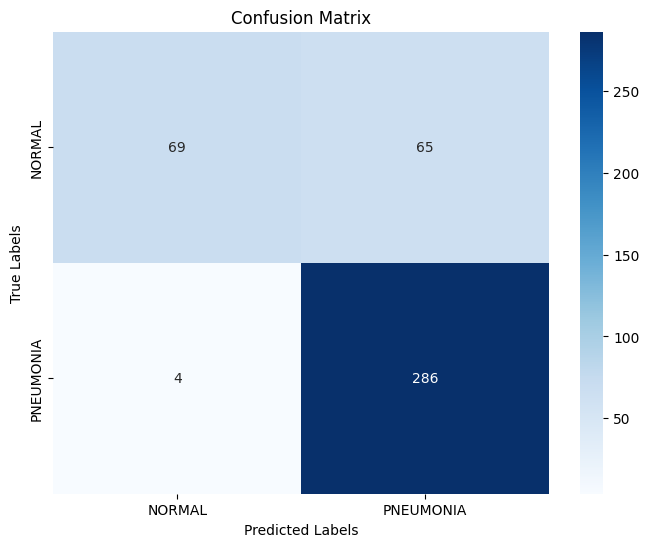

In [ ]:
print(classification_report(test_Y, test_predictions))

cm = confusion_matrix(test_Y, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

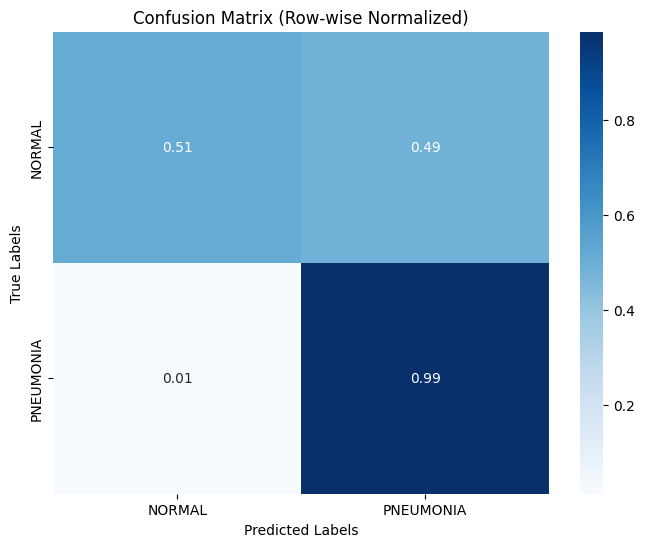

In [ ]:
cm = confusion_matrix(test_Y, test_predictions)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap="Blues",
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix (Row-wise Normalized for Color)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
precision = precision_score(test_Y, test_predictions)
recall = recall_score(test_Y, test_predictions)
f1 = f1_score(test_Y, test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.8148148148148148
Recall: 0.9862068965517241
F1-score: 0.8923556942277691


In [ ]:
#CREATING IMAGES FOR AUGMENTATION

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#WE CREATED TEST IMAGES FROM THE TEST DATA AND TRAIN IMAGES FROM TRAIN DATA TO AVIOD BIAS.

train_generator = datagen.flow_from_directory(
    train,
    target_size=(128, 128),
    batch_size=10000,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5239 images belonging to 2 classes.


In [ ]:
#WE CREATED 5000 FOR TRAINING

Created_train_X, Created_train_Y = next(train_generator)
Created_train_X = flatten_images(Created_train_X)
combined_train_X = np.concatenate((Created_train_X, combined_train_val_X), axis=0)
combined_train_Y = np.concatenate((Created_train_Y, combined_train_val_Y), axis=0)


In [ ]:
#WE WILL USE THE RANDOM FOREST PARAMETERS WE FOUND BEFORE AS OPTIMAL (n_estimators=100, max_depth=30)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, min_samples_leaf=4, min_samples_split=2, max_features='log2')
rf_model.fit(combined_train_X, combined_train_Y)
test_prediction_augmented = rf_model.predict(test_X)

print("Test Accuracy:", accuracy_score(test_Y, test_prediction_augmented))
print("F1 Score:", f1_score(test_Y, test_prediction_augmented))

Test Accuracy: 0.8466981132075472
F1 Score: 0.8976377952755905


              precision    recall  f1-score   support

           0       0.94      0.55      0.69       134
           1       0.83      0.98      0.90       290

    accuracy                           0.85       424
   macro avg       0.88      0.77      0.80       424
weighted avg       0.86      0.85      0.83       424



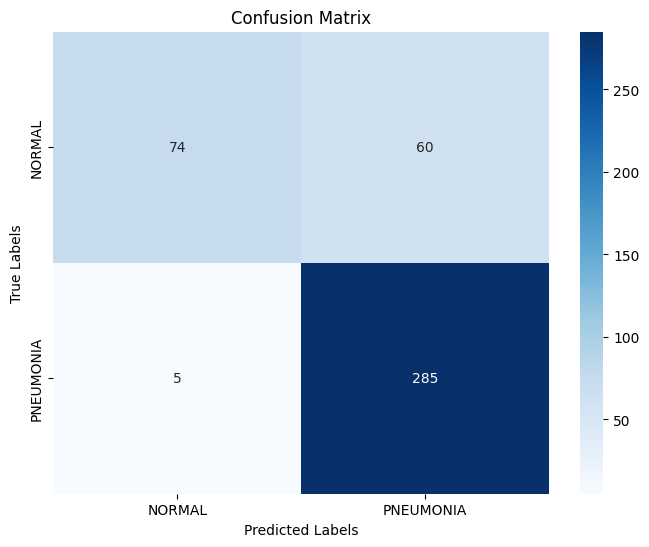

In [ ]:
#PERFORMANCE MATRIX

print(classification_report(test_Y, test_prediction_augmented))

cm = confusion_matrix(test_Y, test_prediction_augmented)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

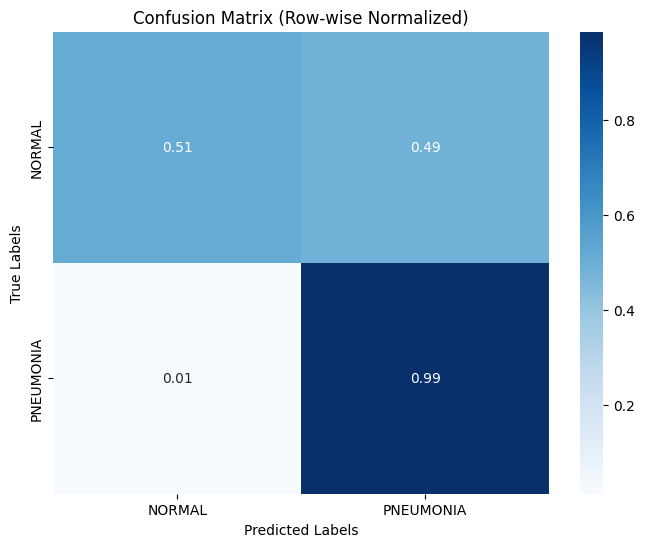

In [ ]:


cm = confusion_matrix(test_Y, test_predictions)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap="Blues",
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title("Confusion Matrix (Row-wise Normalized for Color)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
#PRECISION, RECALL , F-STAT
precision = precision_score(test_Y, test_prediction_augmented)
recall = recall_score(test_Y, test_prediction_augmented)
f1 = f1_score(test_Y, test_prediction_augmented)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.8260869565217391
Recall: 0.9827586206896551
F1-score: 0.8976377952755905


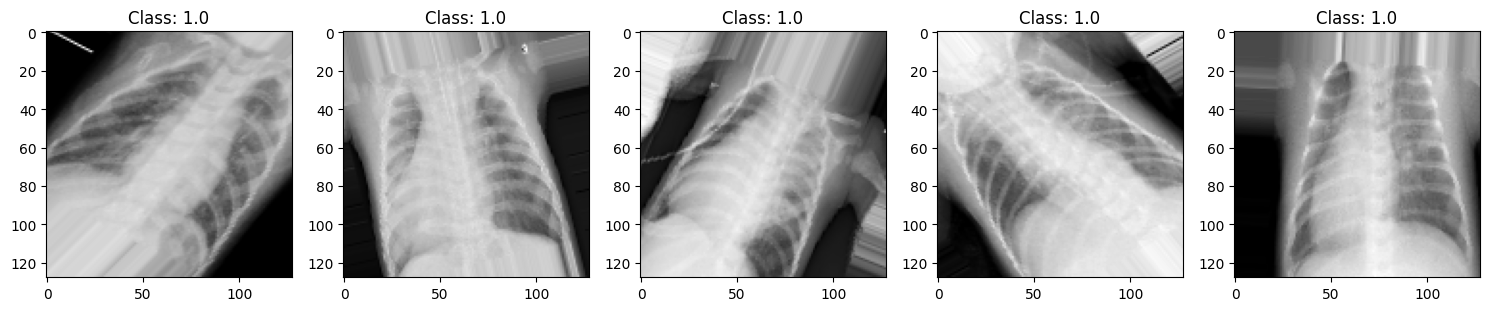

In [ ]:

import matplotlib.pyplot as plt


Created_train_X_reshaped = Created_train_X.reshape(-1, 128, 128)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax = axes[i]
    ax.imshow(Created_train_X_reshaped[i], cmap='gray')
    ax.set_title(f"Class: {Created_train_Y[i]}")

plt.tight_layout()
plt.show()